In [1]:
from project.dataset.prepare import MomentRetrievalDataset
from transformers import VideoLlavaProcessor, VideoLlavaImageProcessor
from project.dataset.collate import DataCollatorWithPadding
from torch import tensor
import numpy as np
import torch
from datasets import load_from_disk
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from torch.utils.data import DataLoader

In [2]:
from matplotlib import pyplot as plt
from PIL import Image

def display_videos(pixel_v):
    # convert to image from proceessed tensors
    clip = pixel_v[0] * 255
    clip = clip.permute(0, 2, 3, 1).clamp(0, 255)

    # np array with shape (frames, height, width, channels)
    video = np.array(clip).astype(np.uint8)

    fig = plt.figure()
    im = plt.imshow(video[0,:,:,:])

    plt.close() # this is required to not display the generated image

    def init():
        im.set_data(video[0,:,:,:])

    def animate(i):
        im.set_data(video[i,:,:,:])
        return im

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                                interval=100)
    HTML(anim.to_html5_video())

In [3]:
def display_images_from_video(pixels, frames):
    clip = pixels[0] * 255
    clip = clip.permute(0, 2, 3, 1).clamp(0, 255)
    fig, axarr = plt.subplots(2, frames//2, figsize = (12, 12))
    fig.tight_layout()

    for i in range(2):
        for j in range(frames // 2):
            curr_frame = Image.fromarray(np.uint8(clip[i*(frames//2) + j]))
            axarr[i, j].imshow(curr_frame)
            axarr[i, j].get_xaxis().set_visible(False)
            axarr[i, j].get_yaxis().set_visible(False)
            axarr[i, j].set_aspect('equal')

    plt.subplots_adjust(wspace=None, hspace=None)
    plt.axis('off')
    plt.show()

In [4]:
processor = VideoLlavaProcessor.from_pretrained('LanguageBind/Video-LLaVA-7B-hf')
processor.patch_size = 14
processor.vision_feature_select_strategy = "default"

In [5]:
mr = MomentRetrievalDataset(base_dir="test/prepare1", processed_dir="processed", processor=processor, num_worker=2)

In [6]:
dataset = mr.prepare_dataset(use_frame=False)
dataset 

Saving the dataset (0/1 shards):   0%|          | 0/50 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/50 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/50 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['pixel_values_videos', 'input_ids', 'attention_mask'],
        num_rows: 50
    })
    test: Dataset({
        features: ['answer', 'pixel_values_videos', 'input_ids', 'attention_mask', 'ts_info'],
        num_rows: 50
    })
    validation: Dataset({
        features: ['answer', 'pixel_values_videos', 'input_ids', 'attention_mask', 'ts_info'],
        num_rows: 50
    })
})

In [7]:
p = dataset['train'][10]['pixel_values_videos']
p.shape

torch.Size([1, 14, 3, 224, 224])

In [8]:
i = dataset['train'][10]['input_ids']
print(processor.batch_decode(i, clean_up_tokenization_space=True, skip_special_tokens=True)[0])

USER: Your task is to determine the timestamp range that best represents an action in the video. Use the provided frame-to-timestamp mapping to associate the timestamps with the actual video frames. Find the most similar continuous sequence of timestamp with the action asked.
Provide your answer as two timestamps in the format "mm:ss, mm:ss" (e.g. "00:10, 00:30"), where the first timestamp is the start time of the action and the second timestamp is the end time of the action. Do not provide any other explanation in your response. 
Video duration: 28 seconds
Frames sampled: 14
The frame-to-timestamp mapping for this video:
Frame 1 at 00:00
Frame 2 at 00:02
Frame 3 at 00:04
Frame 4 at 00:06
Frame 5 at 00:08
Frame 6 at 00:11
Frame 7 at 00:13
Frame 8 at 00:15
Frame 9 at 00:17
Frame 10 at 00:19
Frame 11 at 00:21
Frame 12 at 00:23
Frame 13 at 00:25
Frame 14 at 00:27
Video context: A karate instructor throws a student to the mat grabbing his collar. 
Action in question: The instructor throws 

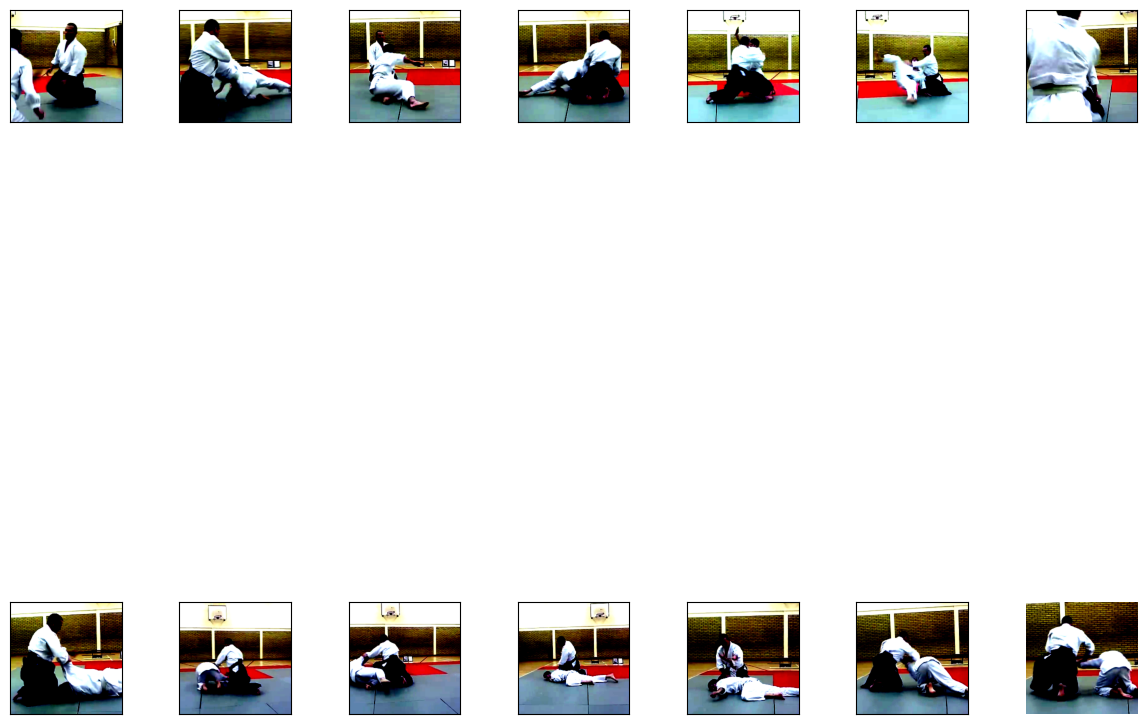

In [9]:
display_images_from_video(p, 14)

In [10]:
dataset['test']['answer']

[['00:15', '00:29'],
 ['00:25', '00:40'],
 ['00:10', '00:33'],
 ['00:06', '00:41'],
 ['00:15', '00:32'],
 ['00:11', '00:20'],
 ['00:00', '00:39'],
 ['00:05', '00:34'],
 ['00:10', '00:15'],
 ['00:21', '00:35'],
 ['00:10', '00:11'],
 ['00:27', '00:46'],
 ['00:05', '00:23'],
 ['00:06', '00:39'],
 ['00:12', '00:28'],
 ['00:14', '00:26'],
 ['00:07', '00:23'],
 ['00:18', '00:33'],
 ['00:06', '00:20'],
 ['00:05', '00:19'],
 ['00:04', '00:20'],
 ['00:04', '00:15'],
 ['00:13', '00:29'],
 ['00:09', '00:23'],
 ['00:05', '00:14'],
 ['00:09', '00:27'],
 ['00:10', '00:33'],
 ['00:10', '00:22'],
 ['00:10', '00:29'],
 ['00:16', '00:29'],
 ['00:00', '00:06'],
 ['00:10', '00:29'],
 ['00:07', '00:10'],
 ['00:11', '00:26'],
 ['00:16', '00:25'],
 ['00:11', '00:27'],
 ['00:07', '00:16'],
 ['00:15', '00:33'],
 ['00:06', '00:22'],
 ['00:11', '00:27'],
 ['00:03', '00:39'],
 ['00:07', '00:28'],
 ['00:06', '00:16'],
 ['00:11', '00:27'],
 ['00:07', '00:46'],
 ['00:10', '00:22'],
 ['00:23', '00:37'],
 ['00:12', '0

In [11]:
dataset['train']['pixel_values_videos'].shape

torch.Size([50, 1, 14, 3, 224, 224])

In [12]:
sum([i.size(1) for i in dataset['train']['input_ids']]) / 50

3997.36